# RNA-seq analysis -- Frodyma, et. al.; 2020
The following notebook details the analyses performed to analyze the RNA-seq data of the PGC1𝛽 or ERR𝛼 knockdown in HCT116 cells.    
Raw data was processed and differential expression analysis using [XPRESSyourself](https://github.com/XPRESSyourself).


### Sequencing Methods
```cDNA libraries of RNA libraries were prepared using _____. cDNA libraries were sequenced at _____ using _____.
Raw sequence data has been deposited as GSE######.
```

### Processing and Analysis Methods
Raw FASTQ files were processed using `XPRESSpipe v 0.4.1`.

Script executed as `sbatch process.sh`

```bash
#!/bin/bash
#SBATCH --time=72:00:00
#SBATCH --nodes=1
#SBATCH -o /scratch/general/lustre/$USER/slurmjob-%j
#SBATCH --partition=kingspeak

#set up the temporary directory
SCRDIR=/scratch/general/lustre/$USER/$SLURM_JOBID
mkdir -p $SCRDIR

FILES=/scratch/general/lustre/$USER/danielle_files/input/files

# Source FASTA files obtained as:
# for X in 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 X Y;  do wget ftp://ftp.ensembl.org/pub/release-99/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.${X}.fa.gz; done
# Source GTF file obtained as:
# wget ftp://ftp.ensembl.org/pub/release-99/gtf/homo_sapiens/Homo_sapiens.GRCh38.99.gtf.gz
REF=/scratch/general/lustre/$USER/references/human_reference_pe_v99

mkdir $SCRDIR/input
mkdir $SCRDIR/output

cp $FILES/*.fastq $SCRDIR/input/

cd $SCRDIR/.

xpresspipe makeReference -o $REF -f $REF/genome_fastas -g $REF/transcripts.gtf --sjdbOverhang 75

xpresspipe peRNAseq -i $SCRDIR/input -o $SCRDIR/output -r $REF --gtf $REF/transcripts.gtf -e frodyma -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT --sjdbOverhang 75 --quantification_method htseq

mkdir $SCRDIR/cufflinks
xpresspipe count -i $SCRDIR/output/alignments_genome -o $SCRDIR/cufflinks -g $REF/transcripts.gtf -c cufflinks -e frodyma
```

### Import dependencies

In [1]:
import pandas as pd 
import numpy as np 
import xpressplot as xp
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

## Differential expression analysis

### Compile counts
1. Samples were run on 4 lanes. Processed read data are compiled for analysis at biological replicate level.
2. Export as two separate tables for the different experimental groups and the control for differential expression analysis

In [2]:
counts = pd.read_csv(
    "./data/frodyma_count_table.tsv",
    sep='\t',
    index_col=0)
counts.columns = [x.split('_')[0] for x in counts.columns.tolist()]
counts = counts.groupby(counts.columns, axis=1).sum()

In [3]:
# Export ERRa counts 
ERRa_counts = counts[[
    'HCT116siCONT1',
    'HCT116siCONT2',
    'HCT116siERRa7',
    'HCT116siERRa8']]

ERRa_counts.to_csv(
    './data/counts_erra.txt',
    sep='\t')

# Export metadata 
ERRa_meta = pd.DataFrame()
ERRa_meta['samples'] = [
    'HCT116siCONT1',
    'HCT116siCONT2',
    'HCT116siERRa7',
    'HCT116siERRa8']
ERRa_meta['conditions'] = [
    'control',
    'control',
    'experiment',
    'experiment']
ERRa_meta = ERRa_meta.set_index('samples')
del ERRa_meta.index.name

ERRa_meta.to_csv(
    './data/metadata_erra.txt',
    sep='\t')

In [4]:
# Export PGC1b counts 
PGC1B_counts = counts[[
    'HCT116siCONT1',
    'HCT116siCONT2',
    'HCT116sipgc1b2',
    'HCT116sipgc1b6']]

PGC1B_counts.to_csv(
    './data/counts_pgc1b.txt',
    sep='\t')

# Export metadata 
PGC1B_meta = pd.DataFrame()
PGC1B_meta['samples'] = [
    'HCT116siCONT1',
    'HCT116siCONT2',
    'HCT116sipgc1b2',
    'HCT116sipgc1b6']
PGC1B_meta['conditions'] = [
    'control',
    'control',
    'experiment',
    'experiment']
PGC1B_meta = PGC1B_meta.set_index('samples')
del PGC1B_meta.index.name

PGC1B_meta.to_csv(
    './data/metadata_pgc1b.txt',
    sep='\t')

### Perform differential expression analysis
Uses `DESeq2 v1.22.1` via the `XPRESSpipe` wrapper

```bash
# ERRa
$ xpresspipe diffxpress -i ./data/counts_erra.txt -s ./data/metadata_erra.txt --design conditions

# PGC1b
$ xpresspipe diffxpress -i ./data/counts_pgc1b.txt -s ./data/metadata_pgc1b.txt --design conditions

# Rename gene IDs as gene names 
$ xpresspipe convertNames -i ./data/counts_erra_diffx.tsv -g ~/Desktop/Homo_sapiens.GRCh38.99.gtf 
$ xpresspipe convertNames -i ./data/counts_pgc1b_diffx.tsv -g ~/Desktop/Homo_sapiens.GRCh38.99.gtf 
```

### Import differential expression data

In [5]:
err_file = "./data/counts_erra_diffx_renamed.tsv"
err_data = pd.read_csv(
    err_file,
    sep='\t',
    index_col=0)
del err_data.index.name

In [6]:
pgc1_file = "./data/counts_pgc1b_diffx_renamed.tsv"
pgc1_data = pd.read_csv(
    pgc1_file,
    sep='\t',
    index_col=0)
del pgc1_data.index.name

### RNA-seq Count Analysis
Genes of interest:
- PCK2 (ENSG00000100889)
- SLC1A4 (ENSG00000115902)
- ESRRA (ENSG00000173153)
- PPARGC1B (ENSG00000155846)

In [7]:
highlight_points = [
    'PCK2',
    'SLC1A4',
    'ESRRA',
    'PPARGC1B']

##### ERRA (ESRRA)

<Figure size 432x288 with 0 Axes>

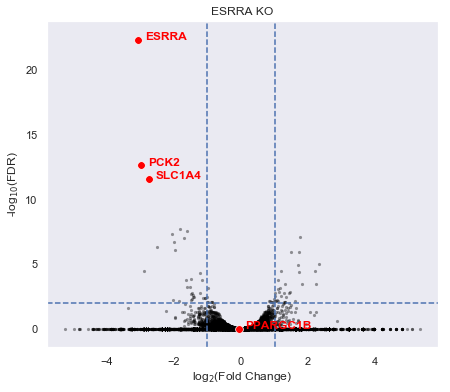

In [8]:
xp.rna_volcano(
    err_file,
    highlight_points=highlight_points,  
    highlight_color='red',
    label_points=highlight_points,
    y_threshold=2, 
    x_threshold=[-1,1],
    size=10,
    highlight_size=60,
    alpha=0.4,
    figsize=(7,6),
    title="ESRRA KO")

##### PGC1B (PPARGC1B)

<Figure size 432x288 with 0 Axes>

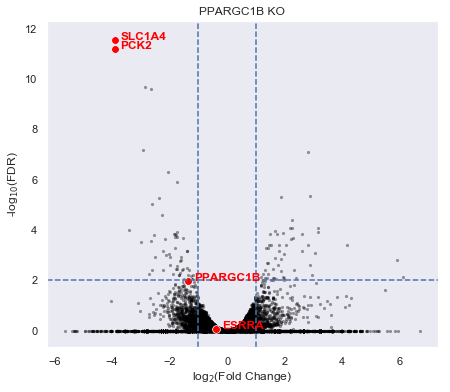

In [9]:
xp.rna_volcano(
    pgc1_file,
    highlight_points=highlight_points,  
    highlight_color='red',
    label_points=highlight_points,
    y_threshold=2, 
    x_threshold=[-1,1],
    size=10,
    highlight_size=60,
    alpha=0.4,
    figsize=(7,6),
    title="PPARGC1B KO")